In [1]:
# load modules
import os
import numpy as np
import pandas as pd
import pickle

# Plotting imports
import matplotlib
import matplotlib.pyplot as plt

import palantir
import scanpy as sc

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
%matplotlib inline

## Download data

Anndata objects with all the data and metadata are publically avaiable at: https://s3.amazonaws.com/dp-lab-data-public/palantir/human_cd34_bm_rep[1-3].h5ad. This notebook use replicate 1 (https://s3.amazonaws.com/dp-lab-data-public/palantir/human_cd34_bm_rep1.h5ad) for illustration. 

Description of the anndata object is available at https://s3.amazonaws.com/dp-lab-data-public/palantir/readme

## Load data

In [4]:
# Load the AnnData object
ad = sc.read('annadata/human_cd34_bm_rep1.h5ad')
colors = pd.Series(ad.uns['cluster_colors'])
ct_colors = pd.Series(ad.uns['ct_colors'])

## FateID

<b>Note:</b> We had used an older version of RaceID/FateID in the manuscript and had not used the recommened parameters. The results with the recommended set of parameters are shown below

We export data and use the FateID R Script to compute the results. The exporting code is shown below

```
# Export data 
fateid_dir = 'fateid/'
os.makedirs(fateid_dir, exist_ok=True)

# Genes
counts = pd.DataFrame(ad.raw.X.todense(), index=ad.obs_names, columns=ad.var_names)
pd.DataFrame(counts.T).to_csv(f'{fateid_dir}/counts.csv')
```

FateID was run with the following R code script

```
require(RaceID)
require(FateID)

# load data
data <- read.csv("fateid/counts.csv",sep=",",header=TRUE)
rownames(data) <- data[,1]
data <- data[,-1]
data <- t(data)

# RaceID clustering
sc <- SCseq(data)
sc <- filterdata(sc, mintotal=10)
sc <- compdist(sc,metric="logpearson")
sc <- clustexp(sc,samp=1000)
sc <- findoutliers(sc)
sc <- comptsne(sc)


# Fate Bias
markers <- list(Erythrocytes = "HBB", Megakaryocytes = "PF4",  DC = "IRF8", Bcell = "EBF1", Monocytes = "LYZ")

x    <- getfdata(sc)[sc@cluster$features,]
z    <- sc@distances 
pa  <- getPart(x,markers,n=50)
y   <- pa$part
tar <- pa$tar

fb  <- fateBias(x,y,tar,z=z,minnr=20,minnrh=20,seed=123)


# Export results
out_dir = 'fateid/'
write.csv(sc@tsne, sprintf("%s/tsne.csv", out_dir))
write.csv(fb$probs, sprintf("%s/probs.csv", out_dir))
write.csv(sc@cluster$kpart, sprintf("%s/clusters.csv", out_dir))
for (i in 1:length(markers)){
    order = fb$tr[sprintf("t%d", i+1)]
    write.csv(order, sprintf("%s/%s_order.csv", out_dir, names(markers)[i]))
}


```

The results from the above run is available at ```results/fateid```

### Load results

In [5]:
# Load results
res_dir = 'results/fateid/'

fateid_probs = pd.read_csv(res_dir + 'probs.csv', index_col=0)
fateid_probs.columns = [ 'Ery', 'Mega', 'DC', 'CLP', 'Mono']

tsne = pd.read_csv(res_dir + 'tsne.csv', index_col=0)
tsne.columns = ['x', 'y']
tsne.index = fateid_probs.index

### RaceID clusters

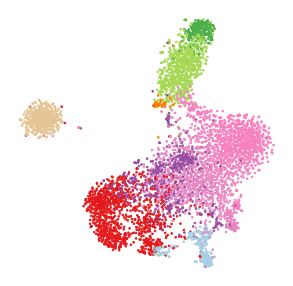

In [6]:
plt.figure(figsize=[5, 5])
plt.scatter(tsne['x'], tsne['y'],
           s=3, color=colors[ad.obs['clusters']])
ax = plt.gca()
ax.set_axis_off()



### Fate Biases

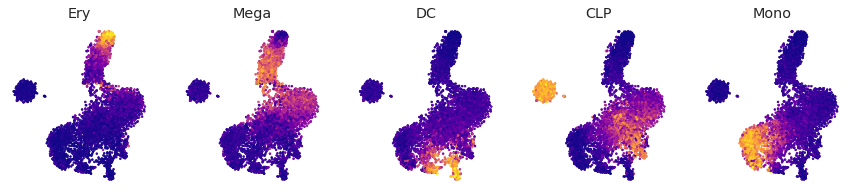

In [7]:
fig = palantir.plot.FigureGrid(fateid_probs.shape[1], fateid_probs.shape[1])

for br, ax in zip(fateid_probs.columns, fig):
    ax.scatter(tsne.loc[:, 'x'], tsne.loc[:, 'y'], s=3,
              c=fateid_probs.loc[tsne.index, br], vmin=0, vmax=1,
              cmap=matplotlib.cm.plasma)
    ax.set_axis_off()
    ax.set_title(br)


### Pseudo-time

In [8]:
from collections import OrderedDict
ct_order = OrderedDict()
for ct in fateid_probs.columns:
    order = pd.read_csv(res_dir + ct+ '_order.csv', index_col=0).iloc[:, 0]
    order = pd.Series(order.index[::-1], index=order)
    ct_order[ct] = order

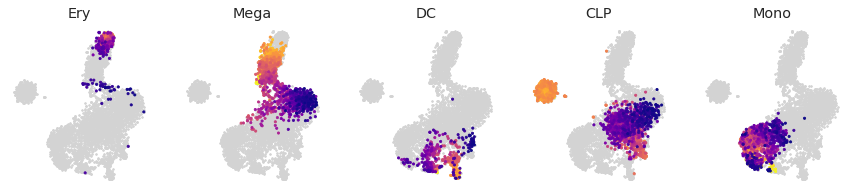

In [9]:
fig = palantir.plot.FigureGrid(fateid_probs.shape[1], fateid_probs.shape[1])

for br, ax in zip(ct_order.keys(), fig):
    order = ct_order[br]
    ax.scatter(tsne.loc[:, 'x'], tsne.loc[:, 'y'], s=3, color='lightgrey')
    ax.scatter(tsne.loc[order.index, 'x'], tsne.loc[order.index, 'y'],
               s=5, c=order, cmap=matplotlib.cm.plasma)
    ax.set_axis_off()
    ax.set_title(br)

### Trends

In [10]:
imputed_data = pd.DataFrame(ad.obsm['MAGIC_imputed_data'],
                           index=ad.obs_names, columns=ad.var_names)

In [11]:
from matplotlib.ticker import FormatStrFormatter

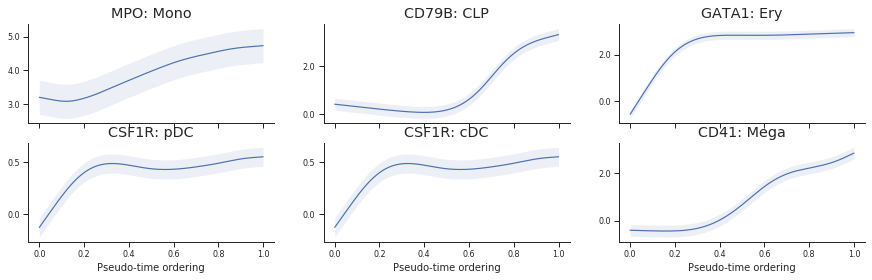

In [12]:
genes = ['MPO', 'CD79B', 'GATA1', 'CSF1R', 'CSF1R', 'ITGA2B']
labels = ['MPO', 'CD79B', 'GATA1', 'CSF1R', 'CSF1R', 'CD41']

gene_lineages = ['Mono', 'CLP', 'Ery', 'DC', 'DC', 'Mega']
gene_branches = ['Mono', 'CLP', 'Ery', 'pDC', 'cDC', 'Mega']

fig = plt.figure(figsize=[5*3, 2 * 2])
i = 1

for gene, label, l, branch in zip(genes, labels, gene_lineages, gene_branches):
    ax = fig.add_subplot(2, 3, i); i = i + 1
    
    # FateId
    res = palantir.presults._gam_fit_predict(ct_order[l].values, 
                                   imputed_data.loc[ct_order[l].index, gene], None)

    order = ct_order[l].index
    bins = ct_order[l]
    bins = (bins - bins.min()) / (bins.max() - bins.min())
    t = res[0]
    stds = res[1]

    # Plot
    ax.plot(bins, t)#, color=lin_colors[l])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.fill_between(bins, (t - stds),
            (t + stds), alpha=0.1)#, color=lin_colors[l])
    ax.set_title(f'{label}: {branch}')

    
    if i < 5 :
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Pseudo-time ordering', fontsize=10)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
